In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
import math
import random

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [2]:
def data_loader(filename):
    data = np.genfromtxt(filename, delimiter=',', dtype=float)
    data = data[data[:,1].argsort()]
    X = data[:,1]
    truth = data[:,0]
    return X, truth

In [6]:
def roc_generator(X, truth, beta_rule='all_stats'):
    assert beta_rule in ['all_stats', 'lin_sample', 'every_nth_stat', 'all_pf_stats', 'lin_sample_pfa']
     
    ftotal = X[truth==0].size
    dtotal = X[truth==1].size
    
    if beta_rule == 'all_stats':
        beta = np.insert(X, 0, -math.inf)
        beta = np.append(beta, math.inf)
    elif beta_rule == 'lin_sample':
        beta = np.linspace(X.min(), X.max(), 99, endpoint=True)
        beta = np.insert(beta, 0, -math.inf)
        beta = np.append(beta, math.inf)
    elif beta_rule == 'every_nth_stat':
        if X.size // 99 != 0:
            n = X.size // 99
            beta = X[n::n]
            assert beta.size == 99, 'Number of sample less than 99.'
        else:
            beta = X        
        beta = np.insert(beta, 0, -math.inf)
        beta = np.append(beta, math.inf)
    elif beta_rule == 'all_pf_stats':
        beta = X[truth==0]
        beta = np.insert(beta, 0, -math.inf)
        beta = np.append(beta, math.inf)
    elif beta_rule == 'lin_sample_pfa':
        h0 = X[truth==0]
        h0_geq_cnt = np.ceil(h0.size*np.linspace(0, 1, 101, endpoint=True))
        beta = sorted([h0[-int(i)] for i in h0_geq_cnt])
        
    coordinates = [] # store each (Pf, Pd) pair under each beta.
    for b in beta:
        fcount, dcount = 0, 0
        for num in X[truth==0]:
            if num >= b:
                fcount += 1
        for num in X[truth==1]:
            if num >= b:
                dcount += 1
        coordinates.append([fcount/ftotal, dcount/dtotal])
    
    return coordinates

In [7]:
def plot_roc(coordinates, mode='all', title=''):
    plt.figure(figsize=(10,10))
    plot_title = title + ' ROC Plot'
    plt.title(plot_title)

    beta_rule = ['all_stats', 'lin_sample', 'every_nth_stat', 'all_pf_stats', 'lin_sample_pfa']
    color_line = {
        '.':'navy',
        '--':'green',
        '-.':'yellow',
        'v':'gray',
        'o':'pink'
    }
    if mode == 'all':
        for b, c in zip(beta_rule, color_line.items()):
            roc_data = coordinates
            roc = np.array(roc_data)
            x, y = roc.T
            plt.plot(x, y, c[0], color=c[1], markersize=4, label=b)
            plt.legend(loc='center right')
    else:
        for ind in mode:
            roc_data = coordinates
            roc = np.array(roc_data)
            x, y = roc.T
            plt.plot(x, y, list(color_line.keys())[ind], color=list(color_line.values())[ind], markersize=4, label=beta_rule[ind])
            plt.legend(loc='center right')

    plt.plot([0, 1], [0, 1],'r--', linewidth=1)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('Detection Rate')
    plt.xlabel('False Alarm Rate')
    plt.show()

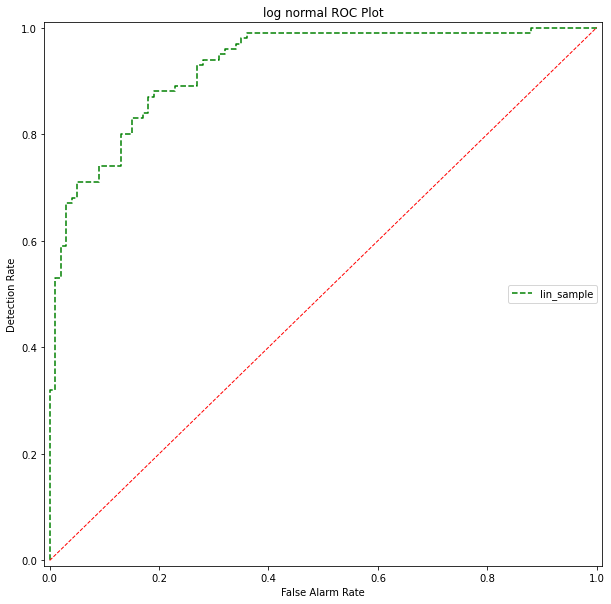

In [8]:
# X, truth = data_loader('logNormalData.csv')
# coord = roc_generator(X, truth)
# plot_roc(coord, mode=[1], title='log normal')

In [4]:
def plot_simple_roc(lambdas, y_tru):
    knn_coord = roc_generator(lambdas, y_true)
    roc = np.array(knn_coord)
    x, y = roc.T
#     plt.figure(figsize=(6,6))
    plt.plot(x, y)
    plt.plot([0, 1], [0, 1],'r--', linewidth=1)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('Detection Rate')
    plt.xlabel('False Alarm Rate')
#     plt.show()
    return plt

In [12]:
def probDecRule(filename):
    data = np.genfromtxt(filename, delimiter=',', dtype=float)
#     data = data[data[:,1].argsort()]
    y_true = data[:,0]
    lambdas = data[:,1]
    h0_ind = [i for i,x in enumerate(y_true) if x==0]
    h1_ind = [i for i,x in enumerate(y_true) if x==1]
    h0_lst = lambdas[h0_ind].tolist()
    h1_lst = lambdas[h1_ind].tolist()
    
    PD=np.zeros(500)
    PFA=np.zeros(500)
    p = .75
    b = .3333
    for i in range(500):
        lst = []
        num_h0 = 0
        num_h1 = 0
        for l,t in enumerate(lambdas.tolist()):
            if t >= b:
                lst.append(1)
            else:
                #lst.append(0)
             
                r = random.uniform(0, 1)
                if r <= p:
                    lst.append(1)
                else:
                    lst.append(0)
    
        lst = np.asarray(lst)
        
        fp = np.sum((lst == 1) & (y_true == 0))
        tp = np.sum((lst == 1) & (y_true == 1))

        fn = np.sum((lst == 0) & (y_true == 1))
        tn = np.sum((lst == 0) & (y_true == 0))
        
        PD[i] = tp / (tp + fn)
        PFA[i] = fp / (fp + tn)
    return PD, PFA

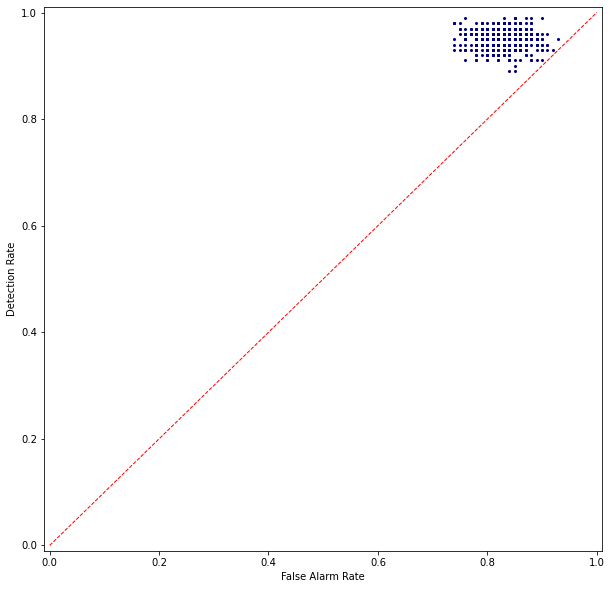

In [17]:
# plt.figure(figsize=(10,10))

# y, x = probDecRule('knn3DecisionStatistics.csv')

# plt.plot(x, y, '.', color='navy', markersize=4)
# plt.plot([0, 1], [0, 1],'r--', linewidth=1)
# plt.xlim([-0.01, 1.01])
# plt.ylim([-0.01, 1.01])
# plt.ylabel('Detection Rate')
# plt.xlabel('False Alarm Rate')
# plt.show()

In [6]:
# Implement two-level cross validation 
# Not used in this project

def cross_validate_svc(X, y, search_space, roc_show=False, img_show=False):
    # configure the cross-validation procedure
    cv_outer = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
    # enumerate splits
    outer_results = list()
    # hyperparameter to update
    acc_to_optimize = 0
    reg_param = np.max(search_space)
    
    # add subplot 
    if roc_show:
        fig, ax = plt.subplots(figsize=(6, 6))
        
#     if img_show:
#         fig2 = plt.figure(figsize=(6, 6))
    
    for i, (train_ix, test_ix) in enumerate(cv_outer.split(X, y)):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
#         print('X train: {} | X test: {}'.format(X_train.shape, X_test.shape))
        y_train, y_test = y[train_ix], y[test_ix]
        # configure the cross-validation procedure
        cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        # define the model
        model = SVC(kernel='linear', C=0.01, max_iter=1e5, random_state=42, probability=True)
        # define search space
        Cs = search_space
        # define search
        search = GridSearchCV(model, param_grid=dict(C=Cs), scoring='accuracy', n_jobs=-1, cv=cv_inner, refit=True)
        # execute search
        result = search.fit(X_train, y_train)
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        # evaluate model on the hold out dataset
        yhat = best_model.predict_proba(X_test)
        # evaluate the model
        acc = best_model.score(X_test, y_test)
        # update hyperparameter
        if acc > acc_to_optimize:
            reg_param = result.best_params_['C']
        # store the result
        outer_results.append(acc)
        # report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        if roc_show:
            plot_roc_curve(best_model, X_test, y_test, ax=ax)
        if img_show:
#             plt.subplot(2, 3, i+1)
            show_chanWeights(np.abs(best_model.coef_[0]))
    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))
    plt.show()
#     clf = SVC(kernel='linear', C=reg_param, max_iter=1e5, random_state=42, probability=True)
#     clf.fit(X, y)
#     opt_acc = clf.score(X, y)
#     print('Accuracy: %.3f' % ((opt_acc)))
#     plot_roc_curve(clf, X, y)